imports

In [1]:
import loss_landscapes
import torch
from HGNN.train import CNN, dataLoader
from HGNN.train.configParser import ConfigParser, getModelName
import os
import numpy as np
from tqdm.auto import tqdm 
import json
import random

import matplotlib.pyplot as plt
from myhelpers import config_plots
config_plots.global_settings()

import loss_surface_plotter
import BGNN_loss
from myhelpers import TrialStatistics

cuda

In [2]:
device=6

# set cuda
if torch.cuda.is_available():
    torch.cuda.set_device(device)

Constants

In [3]:
# generat coord_Tracker_path
dataPath = "/raid/elhamod/Fish"
experimentsPath = "/home/elhamod/HGNN/experiments/" 
trial_hashes = {
    "biology_paper_adaptive_smoothing_betterParams": [
        ["cc40b00a36dea060c97b1a7510dce7b9549c3c22e4cf67e6a3bc5c0f", "faster"],
    ],
    "biology_paper_adaptive_smoothing_betterParams_slower": [
        ["463b814900eec7ffddd644b10c5cec84fb5b7edd90a12fc1878d2050", "slower"],
    ]
} # dictionary of experiments and their [trial hashes, title]


normalize = 'filter' # TODO: fix filter normalization
Do_pca = True # If true, best fitting plane will be found. If false, a random plane will be generated.
STEPS = 20 # resolution of the grid (steps*steps) ALWAYS EVEN
loader_id="train" # 'test', 'train'
DISTANCE=None # None
plot_all_on_same_scale=True # plots all figures on same scale and saves to a separate file with a hash

helper function

In [4]:
def get_model_path(experimentPathAndName, model_hash):
    return os.path.join(experimentPathAndName, "models", model_hash)

def get_model_params(experimentPathAndName, model_hash):
    full_path = os.path.join(get_model_path(experimentPathAndName, model_hash), "params.json")
    with open(full_path) as f:
        experiment_params = json.load(f)
    return experiment_params

In [5]:
def plot_surface_data(loss_data, models, coord_Tracker, title, maxVal=None, minVal=None):
    if maxVal is None:
        maxVal = np.amax([loss_data])
    if minVal is None:
        minVal = np.amin([loss_data])
    
    num_rows=1
    num_columns=1
    STEPS = coord_Tracker.steps_
    DISTANCE = coord_Tracker.dist_

    f, axes = plt.subplots(num_rows, num_columns, figsize=(10, 10), dpi= 300,)

    X = np.array([(k - int(STEPS/2))*DISTANCE/STEPS for k in range(STEPS+1)])
    # X = np.array([(k - int(STEPS/2)) for k in range(STEPS+1)])
    Y = X

    # plot contoues and heatmap
    ax = plt.subplot(num_rows, num_columns, 1)
    contours = plt.contour(X, Y, loss_data, 15, colors='black') # 
    plt.clabel(contours, inline=True, fontsize=10)
    plt.imshow(loss_data, extent=[X[0], X[-1], Y[0], Y[-1]], origin='lower') # , cmap='RdGy', alpha=0.5
    plt.pcolor(X, Y, loss_data, vmin=minVal, vmax=maxVal, cmap='Reds')
    plt.colorbar()

    ax.title.set_text(title) 

    # plot optimzation path
    wm_center = loss_landscapes.wrap_model(models[-1].cuda()).get_module_parameters()
    for i in range(len(models)):
        wm_ = loss_landscapes.wrap_model(models[i].cuda())
        wm = wm_.get_module_parameters()
        scaled_model = loss_landscapes.scale_model(wm, wm_center, coord_Tracker.scaled_dirs_, normalize, DISTANCE, STEPS)
        plt.plot(scaled_model[0], scaled_model[1], marker='o', markersize=4, color="blue")
        value = round(metric(wm_).item(),2)
        if i%10 == 0 or i==len(models)-1:
            plt.text(scaled_model[0], scaled_model[1], value, fontdict={'size'   : 15})
    
    return f

In [6]:
def get_loss_params(loader):
    loader = torch.utils.data.DataLoader(loader.dataset, batch_size=len(loader.dataset))
    batch = next(iter(loader))
    inputs = batch["image"]
    target = batch["fine"]
    meta_target = batch["coarse"]
    return inputs, target, meta_target


def get_loader(loader_id):
    if loader_id == 'validation':
        loader = validation_loader
    elif loader_id == 'test':
        loader = test_loader
    else:
        loader = train_loader
    return loader

def get_loader_loss_params(loader_id):
    return get_loss_params(get_loader(loader_id))

Loop through hashes and generate the plots

In [7]:
max_ = None
min_= None
loss_data_array=[]
coord_Tracker_array=[]
coord_Tracker_path_array=[]
models_array = []

# for all experiments
for experimentName, trial_hashes_ in tqdm(trial_hashes.items(), desc="experiment"):
    print("Experiment: ", experimentName)
    
    experimentPathAndName = os.path.join(experimentsPath, experimentName)
    config_parser = ConfigParser(experimentsPath, dataPath, experimentName)
    datasetManager = dataLoader.datasetManager(experimentPathAndName, dataPath)
    
    # For all models
    for hash_ in tqdm(trial_hashes_, desc="hash"):
        
        hash_, title_ = hash_
        print("Hash: ", hash_)
        
        # Get experiment parameters
        experiment_params = get_model_params(experimentPathAndName, hash_)
        datasetManager.updateParams(config_parser.fixPaths(experiment_params))
        train_loader, validation_loader, test_loader = datasetManager.getLoaders()
        architecture = {
            "fine": len(train_loader.dataset.csv_processor.getFineList()),
            "coarse" : len(train_loader.dataset.csv_processor.getCoarseList())
        }
        
        # Create paths for savign resutls
        model_path = get_model_path(experimentPathAndName, hash_)
        coord_Tracker_path = os.path.join(model_path, 'coordinates', normalize, str(STEPS), str(DISTANCE), loader_id)
        pca_path = os.path.join(model_path, 'coordinates')
        if not os.path.exists(coord_Tracker_path):
            os.makedirs(coord_Tracker_path)

        # get optimization path models
        model_root_path = os.path.join(experimentPathAndName, "models", hash_)
        model_paths = loss_surface_plotter.fetch_model_paths(model_root_path)
        models = loss_surface_plotter.get_models(model_paths, architecture, experiment_params)
        models_array.append(models)
        
        inputs, target, meta_target = get_loader_loss_params(loader_id)
#         metric = BGNN_loss.BGNN_loss_oneBatch(inputs, target, meta_target, experiment_params["lambda"], False, device=device)
        metric = BGNN_loss.BGNN_loss_batched(get_loader(loader_id), experiment_params["lambda"], False, device=device)
        
        coord_Tracker = loss_landscapes.Coordinates_tracker(path=coord_Tracker_path, dirs_path=pca_path, steps_=STEPS, dist_=DISTANCE, device=device)                  
        coord_Tracker_array.append(coord_Tracker)
        coord_Tracker_path_array.append(coord_Tracker_path)

        # Get projections
        if Do_pca:
            if not coord_Tracker.load_dirs():
                coord_Tracker.update_directions(loss_landscapes.get_best_fit_orthogonal_bases_pca(models))
                coord_Tracker.save()
                print("PCA plane basis saved")
            else:
                print("PCA plane basis loaded")

        # Calculate loss data            
        loss_data_file = os.path.join(coord_Tracker_path, "loss_surface_data")
        try:
            loss_data = np.load(loss_data_file+'.npy')
            coord_Tracker.load()
            print("loss surface data  loaded")
        except:
            loss_data = loss_landscapes.random_plane(models[-1], metric, normalization=normalize, deepcopy_model=True, coord_Tracker=coord_Tracker, other_models=models[:-1], device=device)
            np.save(loss_data_file, loss_data)
            print("loss surface data  saved")
        loss_data_array.append(loss_data)
        print("----")
        
        
        # Keep track of the max/min values to plot all on same scale?
        if plot_all_on_same_scale:
            maxVal = np.amax([loss_data])
            if max_ is None or maxVal > max_:
                max_ = maxVal
            minVal = np.amin([loss_data])
            if min_ is None or minVal < min_:
                min_ = minVal

Experiment:  biology_paper_adaptive_smoothing_betterParams


Hash:  cc40b00a36dea060c97b1a7510dce7b9549c3c22e4cf67e6a3bc5c0f
Creating datasets...
Creating datasets... Done.
Creating loaders...
Creating loaders... Done.
67  models added


Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is

Hash:  463b814900eec7ffddd644b10c5cec84fb5b7edd90a12fc1878d2050
Creating datasets...
Creating datasets... Done.
Creating loaders...
Creating loaders... Done.
73  models added


Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is on cpu
Creating model on cpu!
Warning! model is


loss surface data  saved
----




Experiment:  biology_paper_adaptive_smoothing_betterParams


Trial Hash:  cc40b00a36dea060c97b1a7510dce7b9549c3c22e4cf67e6a3bc5c0f
figure hash:  242700588036674405601367317088993754668
----

Experiment:  biology_paper_adaptive_smoothing_betterParams_slower


Trial Hash:  463b814900eec7ffddd644b10c5cec84fb5b7edd90a12fc1878d2050
figure hash:  28629840973391470663854163108298710123
----




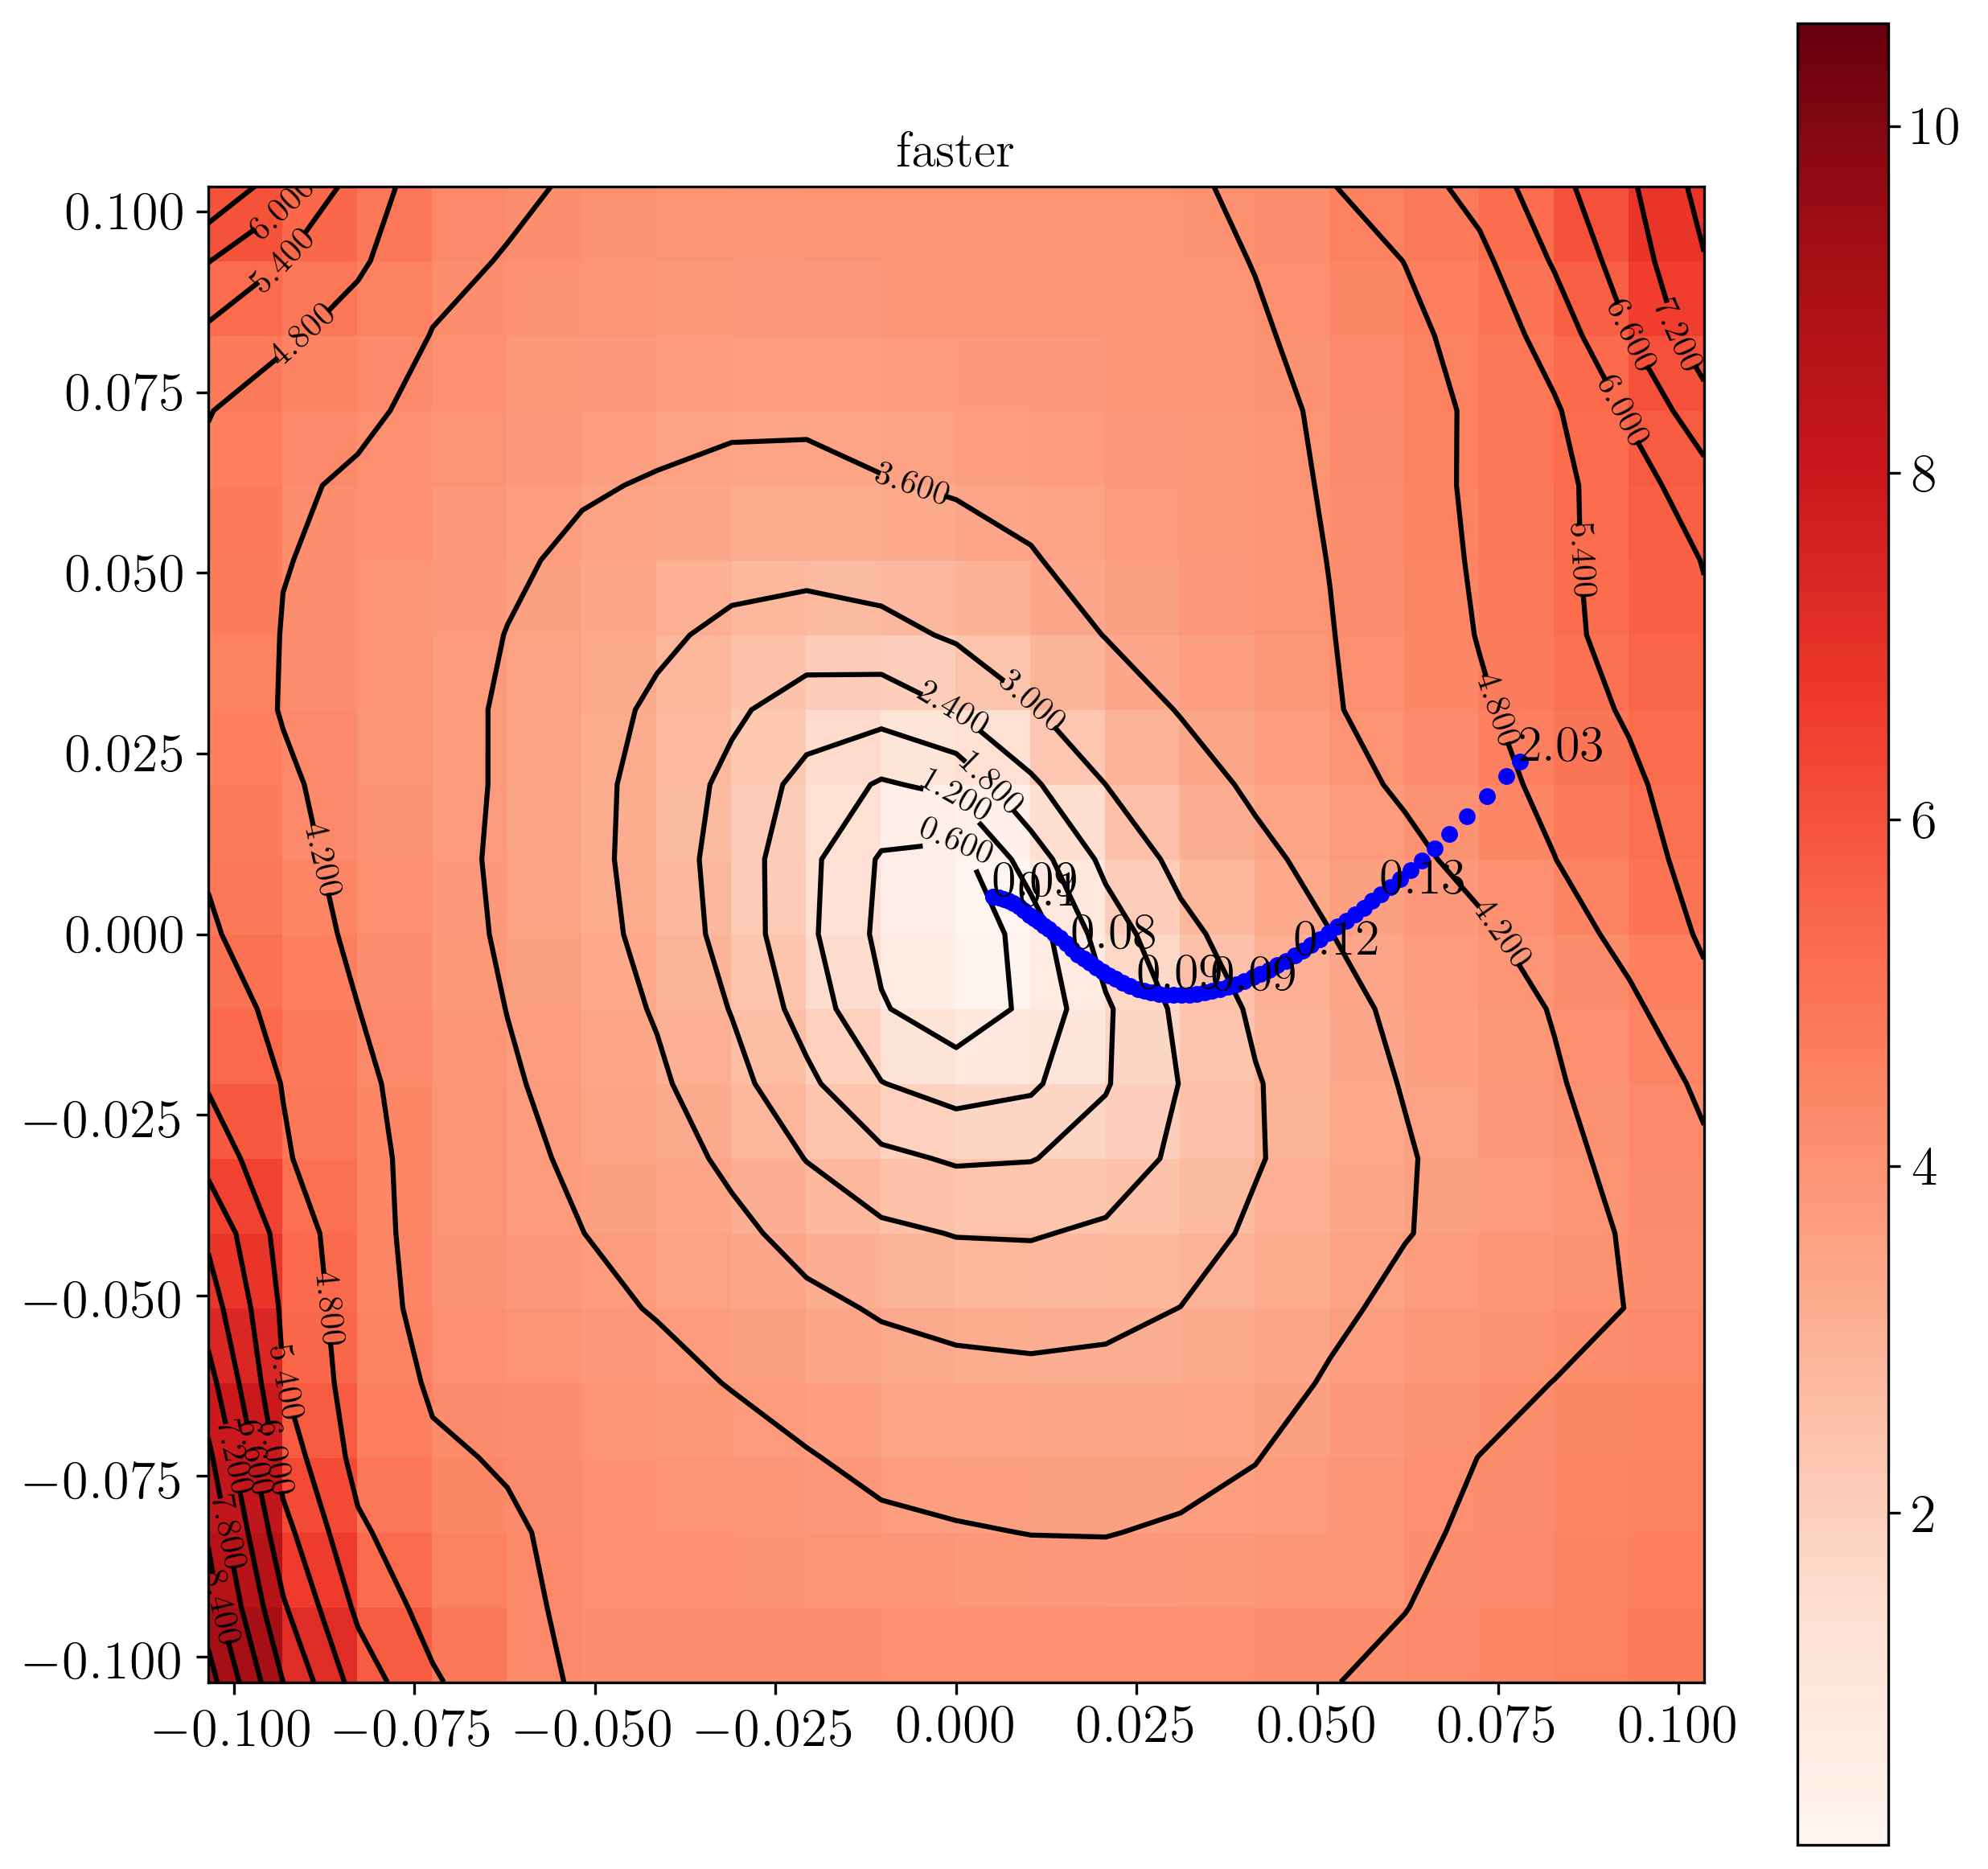

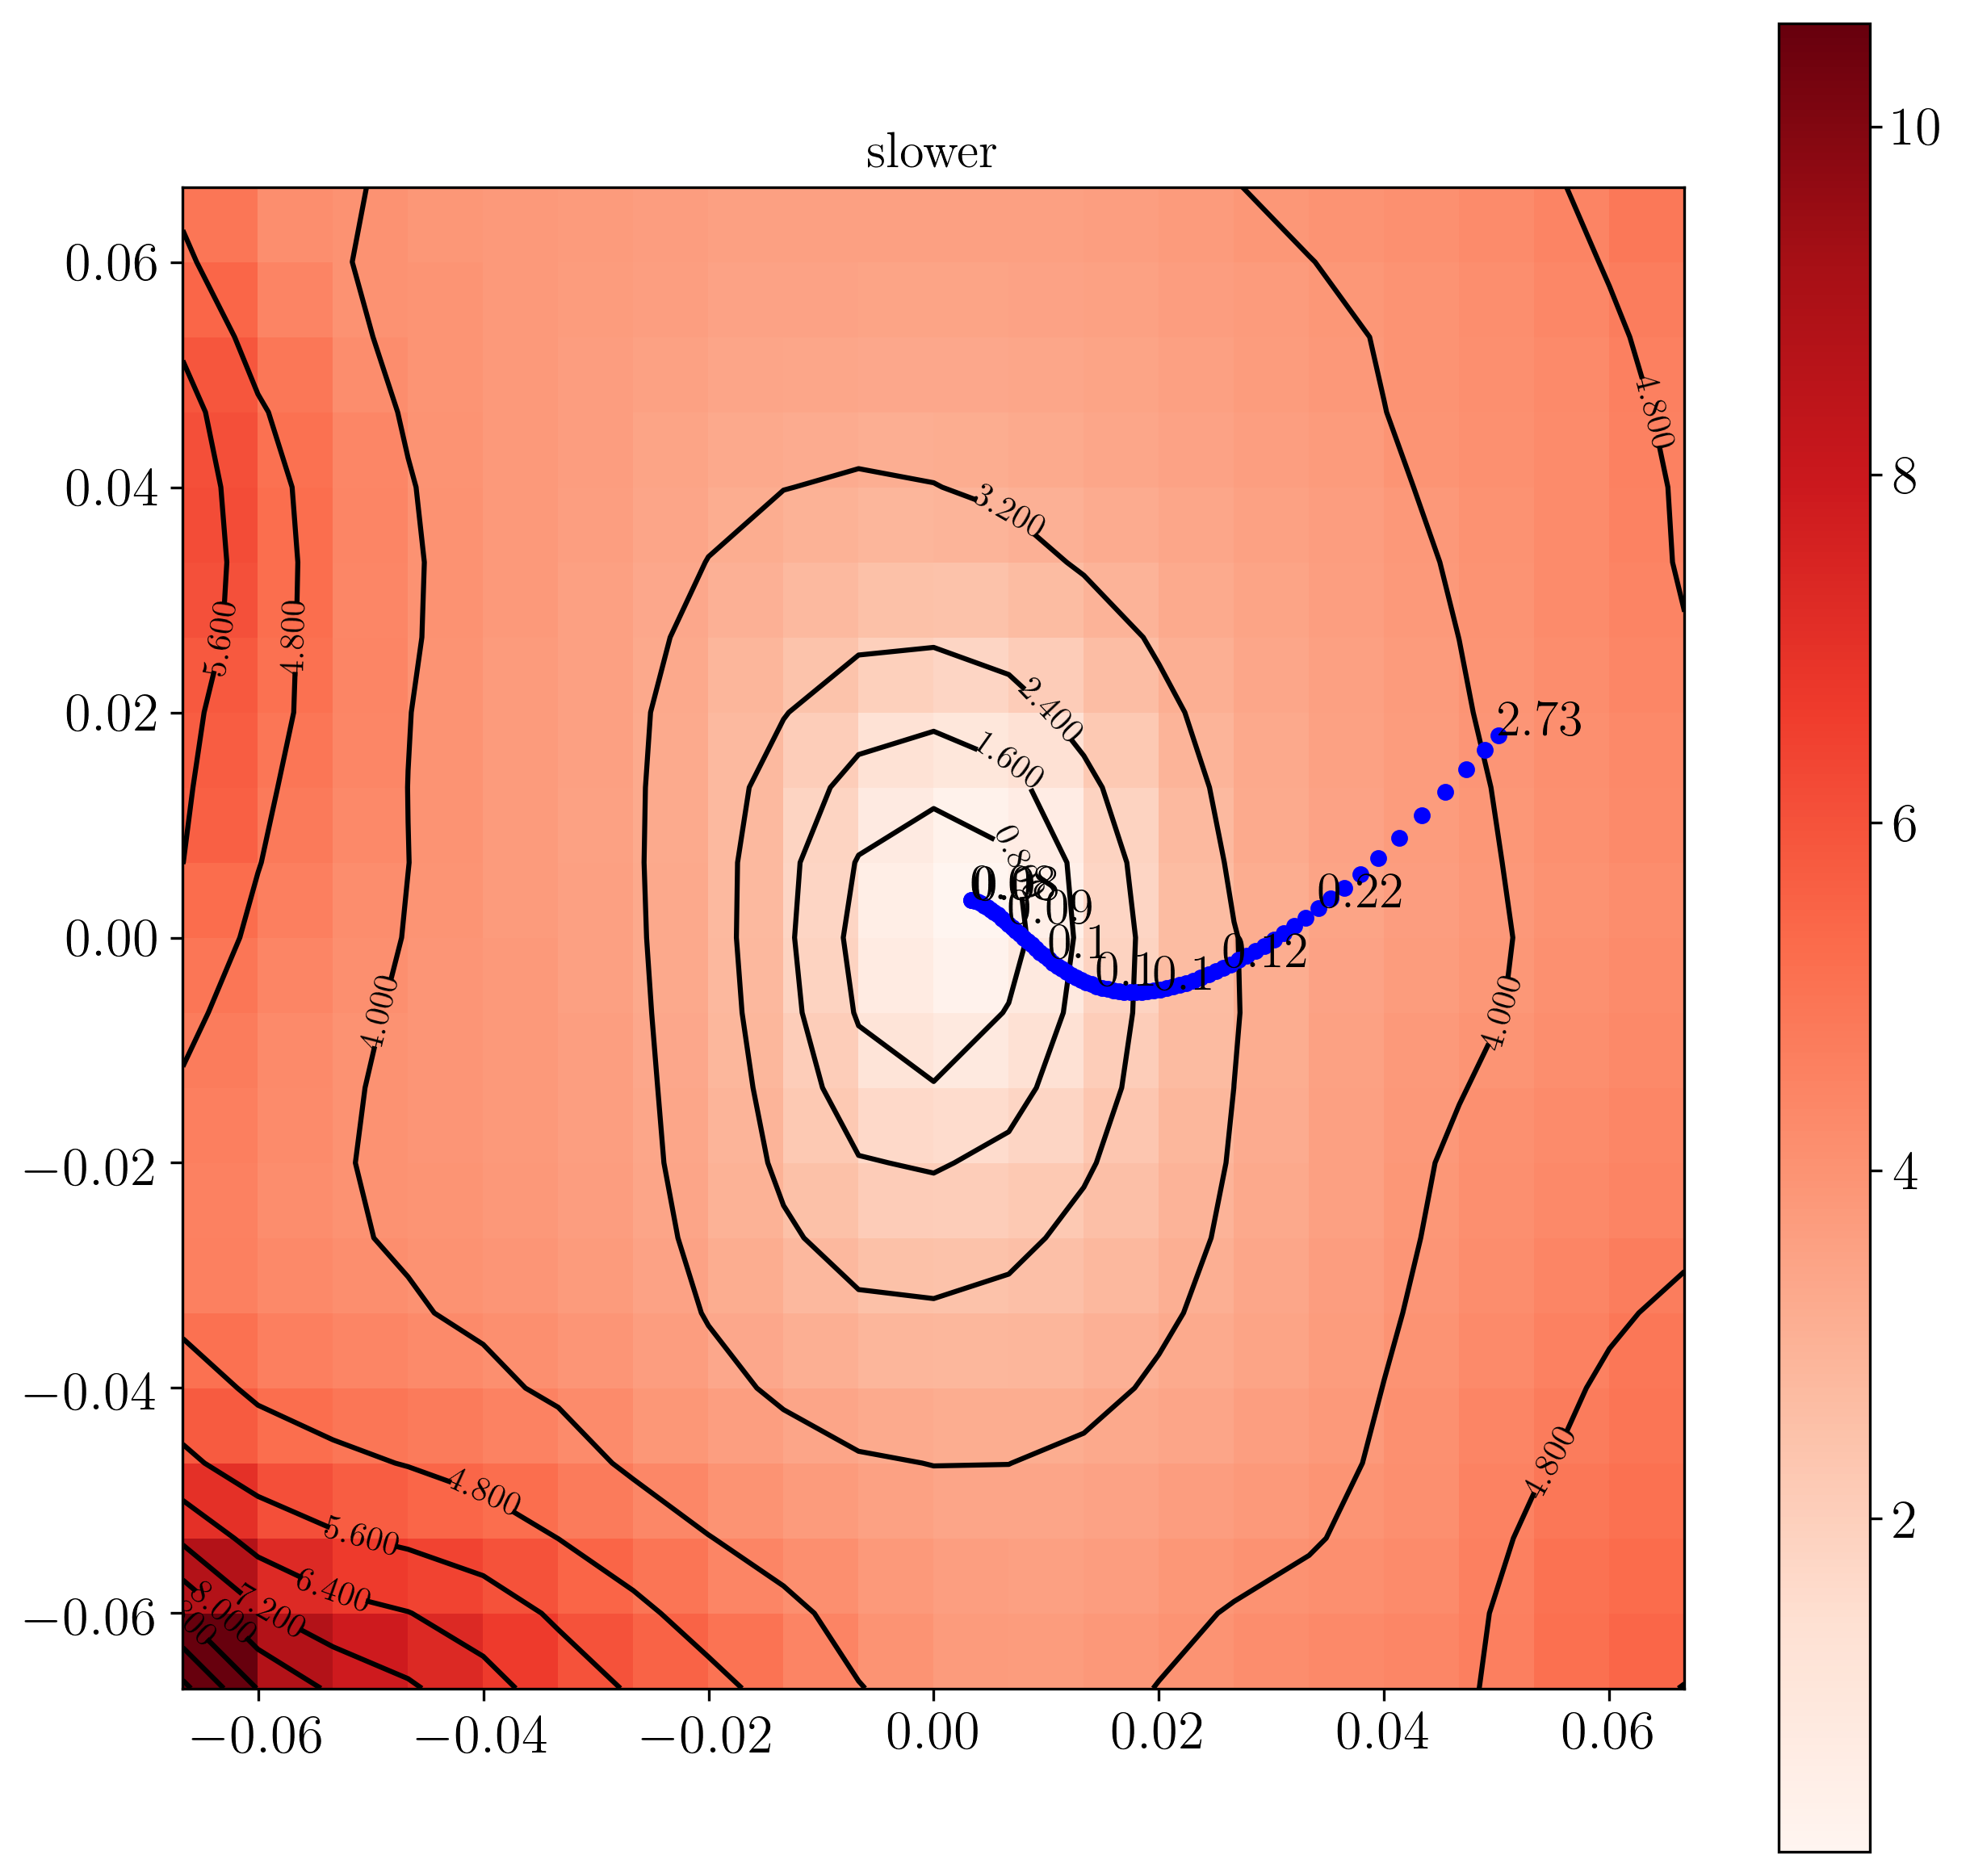

In [8]:
# for all experiments
for experimentName, trial_hashes_ in tqdm(trial_hashes.items(), desc="experiment"):
    print("Experiment: ", experimentName)
    
    # For all models
    for hash_ in tqdm(trial_hashes_, desc="hash"):
        hash_, title_ = hash_
        print("Trial Hash: ", hash_)
        
        coord_Tracker = coord_Tracker_array[0]
        coord_Tracker_array.pop(0) 
        loss_data = loss_data_array[0]
        loss_data_array.pop(0) 
        models = models_array[0]
        models_array.pop(0)
        coord_Tracker_path = coord_Tracker_path_array[0]
        coord_Tracker_path_array.pop(0)

        
        # plot and save      
        f = plot_surface_data(loss_data, models, coord_Tracker, title_, max_, min_)  
        fig_hash = str(random.getrandbits(128))
        print("figure hash: ", fig_hash)
        file_name = "surface_fig.pdf" if (not plot_all_on_same_scale) else "surface_fig_"+fig_hash+".pdf"
        f.savefig(os.path.join(coord_Tracker_path, file_name), bbox_inches = 'tight',)
        print("----")